# Module Three Final Project

For: XX

By: Jonathan E Ericksen, JE Consulting

## Background
> xx

## Objective:
> xx

## Question:
> xx

## Methodology:

> This project loosely follows the industry standard OSEMiN process. The 5 stages in OSEMiN are outlined in the table of contents below with each stage highlighted within the ensuing notebook.

## Table of Contents:<a id='top'></a>
> #### [Obtain](#obtain): 
- Sourcing the data
- Importing data

> #### [Explore](#explore): 
- Data preprocessing, cleaning & wrangling
- Tokenization

> #### [Feature Engineering](#condition):
- xx

> #### [Model](#model):
- Initial Model
- Initial Model Interpretation & Notes
- Data Rebalancing
- Feature engineering
- Hyperparameter tuning
- Initial Cost Benefit analysis
- Model iterations
- Final model

> *(non-OSEMiN additions)*
- **[Cost Benefit Analysis](#costbenefitanalysis)**
- **[Conclusions](#conclusion)**
    - Answer to our business question
- **[Recommendations](#recommendation)**
- **[Future Work](#futurework)**

------------------------------------------------------------------------------------------------------------------

Before we begin, let's import the necessary libraries for our project: 

In [39]:
import pandas as pd

import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros

import re
import nltk as nlp
from nltk.corpus import stopwords
from nltk.probability import FreqDist
nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathanericksen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Obtain <a id='obtain'></a>

[Back to top](#top)

The data used for this project comes from Kaggle and includes a sampling of ~86k tweets sent from both Democratic and Republican representatives in the U.S. congress during May 2018. The dataset can be found here: https://www.kaggle.com/kapastor/democratvsrepublicantweets 

Let's lod the CSV file from kaggle into a pandas dataframe: 

In [2]:
df = pd.read_csv('ExtractedTweets.csv')

------------------------------------------------------------------------------------------------------------------
## Explatory Data Analysis <a id='explore'></a>

[Back to top](#top)

We'll begin our exploratory analysis by calling the standard descriptive methods on the data frame to familiarize ourselves with the features:

In [3]:
display(df.head())
display(df.tail())

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


,Party,Handle,Tweet
86455,Republican,RepTomPrice,Check out my op-ed on need for End Executive O...
86456,Republican,RepTomPrice,"Yesterday, Betty &amp; I had a great time lear..."
86457,Republican,RepTomPrice,We are forever grateful for the service and sa...
86458,Republican,RepTomPrice,Happy first day of school @CobbSchools! #CobbB...
86459,Republican,RepTomPrice,#Zika fears realized in Florida. House GOP act...


Let's confirm there are no null values:

In [5]:
display(df.isnull().sum())

Party     0
Handle    0
Tweet     0
dtype: int64

The first full tweet in the dataset is as follows:

In [71]:
display(df['Tweet'][0])
display(df['Tweet'][1])
display(df['Tweet'][2])
display(df['Tweet'][3])
display(df['Tweet'][4])

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

'RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…'

'RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…'

'RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…'

'RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼\u200d♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY'

We'll separate out the tweets along party lines for further analysis:

In [6]:
democrat = df[(df['Party'] == 'Democrat')]
republican = df[(df['Party'] == 'Republican')]

In [7]:
print('Number of representatives using twitter during May 2018 as follows:')
print()
print('Democrats: {}'.format(democrat['Handle'].nunique()))
print('Republicans: {}'.format(republican['Handle'].nunique()))

Number of representatives using twitter during May 2018 as follows:

Democrats: 211
Republicans: 222


**Number of Tweets by Party**

Let's take a look and the number of tweets sent by party: 

In [8]:
dem_tweets = democrat['Handle'].count()
rep_tweets = republican['Handle'].count()

print('Number of Democratic tweets:', dem_tweets)
print('Number of Republican tweets:', rep_tweets)

Number of Democratic tweets: 42068
Number of Republican tweets: 44392


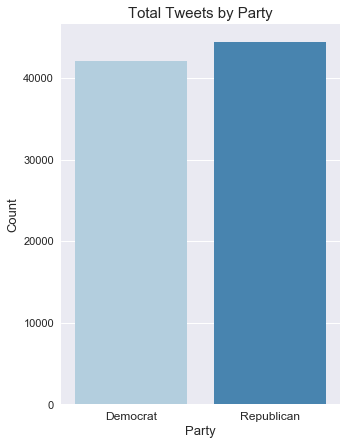

In [14]:
plt.figure(figsize=(5,7))
sns.countplot(x = 'Party', data = df, palette='Blues')
plt.title('Total Tweets by Party', size = 15)
plt.xlabel('Party', size = 13)
plt.ylabel('Count', size = 13)
plt.xticks(size = 12)
plt.yticks(size = 11);

**Common Words by Party**

In [30]:
stopwords = stopwords.words('english')
stopwords += ['rt', 'u', 'amp', 'w', 'th']

In [31]:
#Cleaning democrat party tweets 
democrat_list=[]
for d in democrat.Tweet:
    d=re.sub(r'http\S+', '', d) #remove links
    d=re.sub("[^a-zA-Z]", " ", d) #remove all characters except letters
    d=d.lower() #convert all words to lowercase
    d=nltk.word_tokenize(d) #split sentences into word
    d=[word for word in d if not word in set(stopwords)] #add to stopwords list if unnecessary words.
    lemma=nlp.WordNetLemmatizer() 
    d=[lemma.lemmatize(word) for word in d] #identify the correct form of the word in the dictionary
    d=" ".join(d)
    democrat_list.append(d) #append words to list

In [32]:
republican_list=[]
for r in republican.Tweet:
    r=re.sub(r'http\S+', '', r)
    r=re.sub("[^a-zA-Z]", " ", r)
    r=r.lower()
    r=nltk.word_tokenize(r)
    r=[word for word in r if not word in set(stopwords)]
    lemma=nlp.WordNetLemmatizer()
    r=[lemma.lemmatize(word) for word in r]
    r=" ".join(r)
    republican_list.append(r)

In [35]:
democrat_list[:5]

['today senate dems vote savetheinternet proud support similar netneutrality legislation house',
 'winterhavensun winter resident alta vista teacher one several recognized repdarrensoto national teacher apprecia',
 'nbclatino repdarrensoto noted hurricane maria left approximately billion damage congress allocated',
 'nalcabpolicy meeting repdarrensoto thanks taking time meet latinoleader ed marucci guzman nalcabpolicy',
 'vegalteno hurricane season start june st puerto rico readiness well pwr puertorico repdarrensoto espaillatny']

In [34]:
republican_list[:5]

['wastefulwednesday today introduced bill would eliminate global climate change initiative gc',
 'today honored heroic men woman law enforcement lost life line duty nati',
 'congressmanraja last week repralphnorman hosted briefing economic benefit solar energy production',
 'tegacaypd chief parker thankful receive recognition repralphnorman delivered mayor davidloneal national police',
 'visited sc highway patrol bring cupcake thank service honor']

In [36]:
democrat_tweets=str(democrat_list).split()
republican_tweets=str(republican_list).split()

democrat_tweets=[word.replace("'","") for word in democrat_tweets ]
democrat_tweets=[word.replace("[", "") for word in democrat_tweets ]
democrat_tweets=[word.replace("]","") for word in democrat_tweets ]
democrat_tweets=[word.replace(",", "") for word in democrat_tweets ]

republican_tweets=[word.replace("'","") for word in republican_tweets ]
republican_tweets=[word.replace("[", "") for word in republican_tweets ]
republican_tweets=[word.replace("]","") for word in republican_tweets ]
republican_tweets=[word.replace(",", "") for word in republican_tweets ]

In [37]:
print("Democrat tweets word length:",len(democrat_tweets))
print("Republican tweets word length:",len(republican_tweets))

Democrat tweets word length: 443138
Republican tweets word length: 457293


In [38]:
#FreqDist records the number of times each words are used. 
fdist_democrat = FreqDist(democrat_tweets)
fdist_republican=FreqDist(republican_tweets)

In [79]:
print('Most common words used by Democrats:')
display(fdist_democrat)
print('-'*100)
print('Most common words used by Republicans:')
display(fdist_republican)

Most common words used by Democrats:


FreqDist({'today': 3850, 'trump': 2502, 'american': 2053, 'year': 1835, 'thank': 1777, 'family': 1694, 'great': 1676, 'student': 1660, 'day': 1571, 'congress': 1518, ...})

----------------------------------------------------------------------------------------------------
Most common words used by Republicans:


FreqDist({'today': 4883, 'tax': 2885, 'great': 2876, 'house': 2382, 'bill': 2379, 'american': 2241, 'thank': 2118, 'year': 1961, 'day': 1887, 'act': 1820, ...})

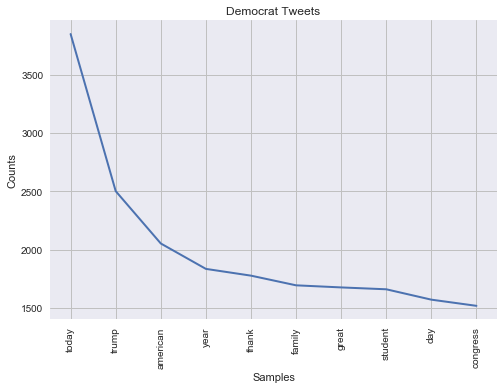

In [82]:
plt.plot(figsize = (10,5))
fdist_democrat.plot(10, title = "Democrat Tweets")

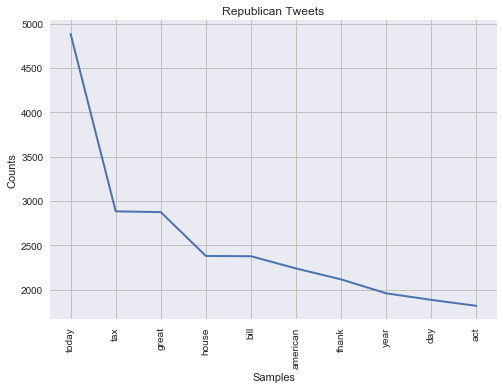

In [83]:
plt.plot(figsize = (10,5))
fdist_republican.plot(10, title="Republican Tweets")

------------------------------------------------------------------------------------------------------------------
## Feature Engineering<a id='condition'></a>

[Back to top](#top)

**Data Cleaning**

Let's again take a look at the some full tweets to get a sense of special characters, symbols, links, et cetera that we'll later need filter out before tokenizing the text: 

In [10]:
display(df['Tweet'][0])
display(df['Tweet'][1])
display(df['Tweet'][2])
display(df['Tweet'][3])
display(df['Tweet'][4])

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

'RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…'

'RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…'

'RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…'

'RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼\u200d♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY'

We'll begin the data cleaning process by establishing a list of stopwords to be removed from the text: 

In [12]:
stopwords = stopwords.words('english')
stopwords += ['rt', 'u', 'amp', 'w', 'th']

As we see in the text, there are multiple characters that need removing before we can tokenize the text data. Let's build a processing function that takes in a string and returns the cleaned text:

In [16]:
def clean_text(tweet):
    #tweet = remove_tags(tweet) # Removing html tags
    tweet = re.sub('[^a-zA-Z]', ' ', tweet) # Remove punctuations and numbers
    tweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', tweet) # Single character removal
    tweet = re.sub(r'\s+', ' ', tweet) # Removing multiple spaces
    tweet = tweet.lower() # Lower case all words
    return tweet

Now that we have our cleaning function, we'll create a list object and and append to it all the tweets that have been run through our clean_text function:

In [17]:
X = []
tweets = list(df['Tweet'])
for tweet in tweets:
    X.append(clean_text(tweet))

Let's compare the original tweets to the now cleaned text set: 

In [18]:
display(df['Tweet'][0])
display(df['Tweet'][1])
display(df['Tweet'][2])
display(df['Tweet'][3])
display(df['Tweet'][4])

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

'RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…'

'RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…'

'RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…'

'RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼\u200d♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY'

In [19]:
X[:5]

['today senate dems vote to savetheinternet proud to support similar netneutrality legislation here in the house https co tggdlu l',
 'rt winterhavensun winter haven resident alta vista teacher is one of several recognized by repdarrensoto for national teacher apprecia ',
 'rt nbclatino repdarrensoto noted that hurricane maria has left approximately billion in damages congress has allocated about ',
 'rt nalcabpolicy meeting with repdarrensoto thanks for taking the time to meet with latinoleader ed marucci guzman nalcabpolicy ',
 'rt vegalteno hurricane season starts on june st puerto rico readiness well pwr puertorico repdarrensoto espaillatny']

**Convert Labels to Integers**

Now that our text data is cleaned, we'll need to convert our labels into digits so we can run them through our models. For our data, we'll make Democrat tweets a 1 and republican tweets a 0:

In [33]:
y = df['Party']
y = np.array(list(map(lambda x: 1 if x=='Democrat' else 0, y)))
print(y)
print(y.shape)

[1 1 1 ... 0 0 0]
(86460,)


**Train Test Split**

We'll split our data using the train_test_split method from sklearn with 20% as the test set and 80% as the train set:

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Tokenize**

In [69]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [70]:
print('Length for train set: ',len(X_train))
print('Length for test set: ',len(X_test))

Length for train set:  69168
Length for test set:  17292


**Padding**

In [71]:
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding = 'post', maxlen = 100)
X_test = pad_sequences(X_test, padding = 'post', maxlen = 100)

In [72]:
print('Number of unique words in our corpus:', vocab_size)

Number of unique words in our corpus: 110140


In [73]:
X_train[50]

array([  62,   25,   47, 1798,  563,  196, 2083,    6,   25,   27,   49,
       2174, 2083,    6,   49,  268,  722, 1304,    7,    3,    2, 3249,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

**Embeddings**

In [78]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

In [79]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

------------------------------------------------------------------------------------------------------------------
## Modeling <a id='model'></a>

[Back to top](#top)

#### Initial Model

Let's begin the modeling portion of the project by fitting our first model to the current data. We'll use the results of this model as our baseline from which improve the overall model performance by tuning the hyperparameters and feature engineering. We'll start by splitting the data into our training and testing sets:

In [25]:
x_train, x_test, y_train, y_test = train_test_split(feats, target, test_size = .20)

Fit the model:

In [26]:
logreg = LogisticRegression(random_state=11)
model_log = logreg.fit(x_train, y_train)

Now that we have our baseline model, let's see how it performs on our training set: 

In [27]:
y_hat_train = logreg.predict(x_train)
residuals = np.abs(y_train - y_hat_train)

print('Model Predictions:')
print()
print(pd.Series(residuals).value_counts())
print()
print(pd.Series(residuals).value_counts(normalize=True))
print('-' * 50)
print('Performance Metrics:')
print()
print('Recall: {}'.format(recall_score(y_train, y_hat_train)))
print('Precision: {}'.format(precision_score(y_train, y_hat_train))) 
print('Accuracy: {}'.format(accuracy_score(y_train, y_hat_train)))

Model Predictions:

0    8725
1    1139
Name: Revenue, dtype: int64

0    0.88453
1    0.11547
Name: Revenue, dtype: float64
--------------------------------------------------
Performance Metrics:

Recall: 0.3882047958522359
Precision: 0.7544080604534005
Accuracy: 0.884529602595296


The model performed decently well on the training set with a 88% accuracry score. Let's see how it performs on the testing set: 

In [28]:
y_hat_test = logreg.predict(x_test)
residuals = np.abs(y_test - y_hat_test)

print('Model Predictions:')
print()
print(pd.Series(residuals).value_counts())
print()
print(pd.Series(residuals).value_counts(normalize=True))
print('-'* 50)
print('Performance Metrics:')
print()
print('Recall: {}'.format(recall_score(y_test, y_hat_test)))
print('Precision: {}'.format(precision_score(y_test, y_hat_test))) 
print('Accuracy: {}'.format(accuracy_score(y_test, y_hat_test)))

Model Predictions:

0    2192
1     274
Name: Revenue, dtype: int64

0    0.888889
1    0.111111
Name: Revenue, dtype: float64
--------------------------------------------------
Performance Metrics:

Recall: 0.4
Precision: 0.7263681592039801
Accuracy: 0.8888888888888888


Again, not bad. The model returned about the same accuracy score as with the training set. The precision score dropped slightly but some variation here is to be expected. Because the training and testing scores are relatively aligned, we can be confident the model is not over fitted. 

Let's further analyze the test set results by visualizing the confusion matrix on the test set using seaborn: 

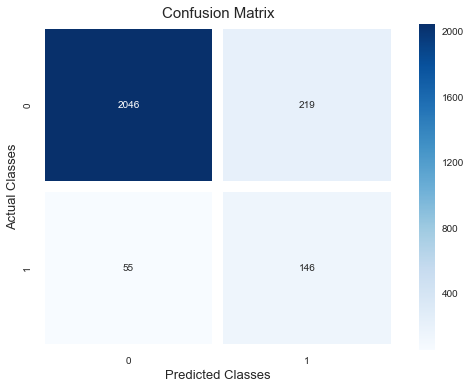

In [29]:
cnf_matrix = confusion_matrix(y_hat_test, y_test)

plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap= 'Blues', linewidths=10, )
plt.title('Confusion Matrix', size= 15)
plt.xlabel('Predicted Classes', size = 13)
plt.ylabel('Actual Classes', size = 13);

#### Notes on Initial Model Results

------------------------------------------------------------------------------------------------------------------
#### Rebalancing

During the EDA phase, we saw how our target feature was imbalanced. These imbalances can give us false confidence in some of our model evaluation metrics. To solve for this, we'll rebalance the data set using the SMOTE method: 

------------------------------------------------------------------------------------------------------------------

#### Feature Engineering

------------------------------------------------------------------------------------------------------------------
#### Hyperparameter Tuning

Now that we have solved for collinearity, baseline model fitted, the data has been normalized and rebalanced, and the most significant features identified, it's time to run the grid search to identify some suggested hyperparamaters for the remaining model iterations. We'll run our grid search using GridsearchCV package available with sklearn:

In [38]:
x_train, x_test, y_train, y_test = train_test_split(scaled_feats, scaled_target, test_size = .20)

grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"], 'fit_intercept':['True', 'False'], 
        'class_weight': ['balanced', None]}

logreg = LogisticRegression(random_state=15)
logreg_cv = GridSearchCV(logreg,grid, cv=3)
logreg_cv.fit(x_train, y_train)

print("Tuned Hyperparameters: ",logreg_cv.best_params_)
print("Accuracy: ",logreg_cv.best_score_)

Tuned Hyperparameters:  {'C': 0.001, 'class_weight': None, 'fit_intercept': 'True', 'penalty': 'l1'}
Accuracy:  0.8375412293853074


 ------------------------------------------------------------------------------------------------------------------

#### Cost Benefit: Financial Implications

Before moving on with further model iterations, we'll take a step back and assess the financial implications for our logistic regression predictions with respect to the use case at Amazon Inc. Each model prediction will have an impact on Amazon's revenue. Let's break down the financial impact of these predictions:

- *True Negative:* **Cost** = ~125 dollars
    - Amazon will lose out on 125 dollars of revenue if a shopper does not make a purchase and is not offered the 10 percent discount.
- *False Positive:* **Cost** = ~237.5 dollars
    - Amazon will lose ~112.5 dollars in lost revenue if our model predicts a shopper will transact, but instead they do not. In this case, the model will instruct the website not to offer a 10 percent discount, thus lost opportunity to entice revenue from a potential sale is: 125 - discount of 12.5 = -112.5 dollars
    - Further, we'll factor in an additional revenue penalty that accounts for the portion of first time shoppers that do not transact. In this scenario, first time shoppers will not experience the seamless experience of shopping at Amazon and will be less likely to be repeat shoppers. This additional revenue penalty will equal 125 dollars in lost potential future revenue.
- *False Negative:* **Benefit** = ~112.5 dollars
    - Amazon will earn ~112.5 dollars in revenue if the model predicts a shopper will not transact, thus a 10 percent discount is offered, and the shopper makes the purchase: 125 - 12.5 percent discount = 112.5 dollars. 
- *True Positive:* **Benefit** = 200 dollars
     - Amazon will earn 125 dollars in revenue if our model correctly predicts a shoppers propensity to transact, thus no offer is made.
     - Further, additional revenue has been added to account for repeat shoppers. Visitors who experience shopping at Amazon are inclined to be repeat shoppers. Thus, additional revenue benefit of 75 dollars has been factored in.
     
*Key Assumptions:*
- *Figures are based on one shopping session*
- *Avg. shopping session purchase = ~125 dollars*
- *Avg. discount to entice shoppers to transact = ~10 percent*


***Target Metric: Precision***
- Based upon the financial impact analysis above, it's important going forward to build a model that limits Type I errors. Thus, we want a model that reflects high precision which limits the costs associated with false positive predictions. 

With these figures in mind, let's assign the appropriate cost/benefit revenue figures for each of the predictions our ensuing model iterations will produce:

In [268]:
TN = -125
FP = -237.5
FN = 112.5
TP = 200

------------------------------------------------------------------------------------------------------------------

#### Model Iterations

Now that have our suggested hyperparameters, let's iterate on a number of models to find the best parameters and features for optimizing precision.

We'll start here by defining a function that takes in the logreg variable with the desired parameters and returns the needed cost/benefit figures along with the precision score and confusion matrix. We'll use this function for our model iterations

In [269]:
def model(logreg):
    model_log = logreg.fit(x_train, y_train)

    y_hat_test = logreg.predict(x_test)
    y_hat_train = logreg.predict(x_train)
    y_test_score = logreg.decision_function(x_test)
    y_train_score = logreg.decision_function(x_train)

    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
    
    print('Models Test Data Precision: {}'.format(precision_score(y_test, y_hat_test).round(3))) 
    
    print('Train Data AUC: {}'.format(auc(train_fpr, train_tpr).round(3)))
    print('Test Data AUC: {}'.format(auc(test_fpr, test_tpr).round(3)))
    
    cnf_matrix = confusion_matrix(y_test, y_hat_test)
   
    tn_cost = ((cnf_matrix[0][0] / len(y_test)) * TN)
    fp_cost = ((cnf_matrix[0][1]/len(y_test)) * FP)
    fn_ben = ((cnf_matrix[1][0]/len(y_test)) * FN)
    tp_ben = ((cnf_matrix[1][1]/len(y_test)) * TP)
    
    print()
    print('Cost/Benefit = {} Dollars Per Shopping Session'.format((tn_cost+fp_cost+fn_ben+tp_ben).round(2)))
    print()
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap= 'Blues', linewidths=10)
    plt.title('Confusion Matrix', size= 15)
    plt.xlabel('Predicted Classes', size = 13)
    plt.ylabel('Actual Classes', size = 13);
    
    print()
    
    plt.figure(figsize=(8,6))
    plt.plot(test_fpr, test_tpr, color = 'blue', lw = 2, label ='Test ROC curve')
    plt.plot(train_fpr, train_tpr, color = 'grey', lw = 2, label ='Train ROC curve')

    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])

    plt.xlabel('False Positive Rate', size = 12)
    plt.ylabel('True Positive Rate', size = 12)
    plt.title('Receiver operating characteristic (ROC) Curve', size = 14)
    plt.legend(loc="lower right");
    

Next, we'll remove all features from the scaled_feats data set beside 'PageValues','Administrative', 'ProductRelated', 'BounceRates' for running the next iteration of models:

In [270]:
scaled_feats = scaled_feats[['PageValues', 'Administrative', 'ProductRelated', 'BounceRates']]

We'll split a new training and testing set with the remaining features and our target:

In [271]:
x_train, x_test, y_train, y_test = train_test_split(scaled_feats, scaled_target, test_size = .20)

***Model 1***
- Suggested hyperparameters from grid search
- Four features deemed significant based on high coefficients and correlation with the target variable

Let's instantiate the Logistic Regression method with the appropriate parameters:

In [272]:
logreg = LogisticRegression(penalty = 'l1', class_weight = 'balanced', fit_intercept = True, C = .001)

And run our first model:

Models Test Data Precision: 0.887
Train Data AUC: 0.906
Test Data AUC: 0.909

Cost/Benefit = 23.57 Dollars Per Shopping Session




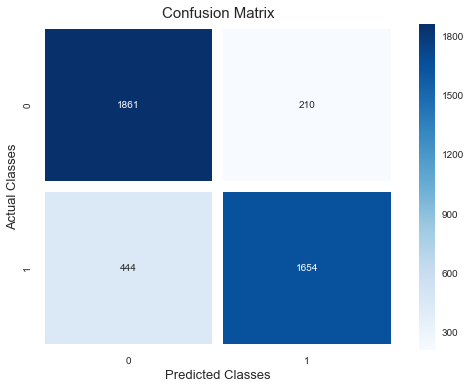

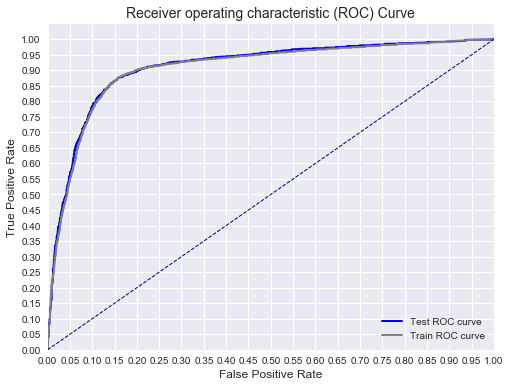

In [273]:
model(logreg)

***Model 2***
- Hyperparameters we've chosen ourselves
- Four features deemed significant based on high coefficients and correlation with the target variable

In [274]:
logreg = LogisticRegression(penalty = 'l2', fit_intercept = True, C = .001, max_iter = 100, tol = 0.0001)

Models Test Data Precision: 0.871
Train Data AUC: 0.896
Test Data AUC: 0.9

Cost/Benefit = 21.5 Dollars Per Shopping Session




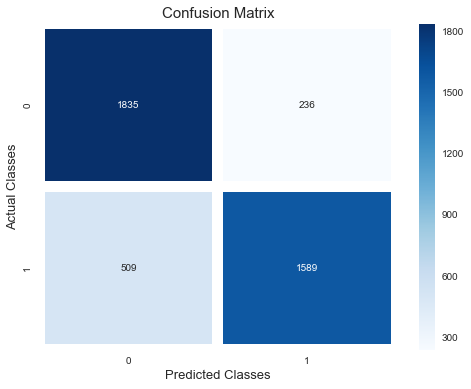

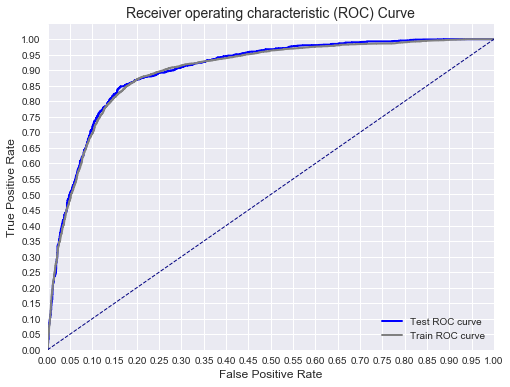

In [275]:
model(logreg)

***Model 3***
- Hyperparameters suggested by the grid search
- One feature suggested by the RFECV function and coefficients

We'll start here by removing all features beside 'PageValues' and generating another train_test_split with our single feature for running the final models:

In [276]:
scaled_feats = scaled_feats[['PageValues']]

In [277]:
x_train, x_test, y_train, y_test = train_test_split(scaled_feats, scaled_target, test_size = .20)

Instantiate a new Logistic Regression method with differing parameters and assign it to logreg variable:

In [278]:
logreg = LogisticRegression(penalty = 'l1', class_weight = 'balanced', fit_intercept = True, C = .001)

Models Test Data Precision: 0.91
Train Data AUC: 0.899
Test Data AUC: 0.897

Cost/Benefit = 23.89 Dollars Per Shopping Session




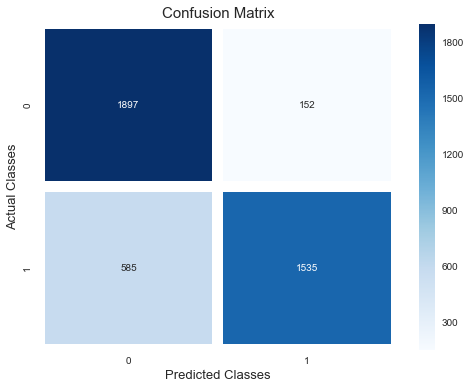

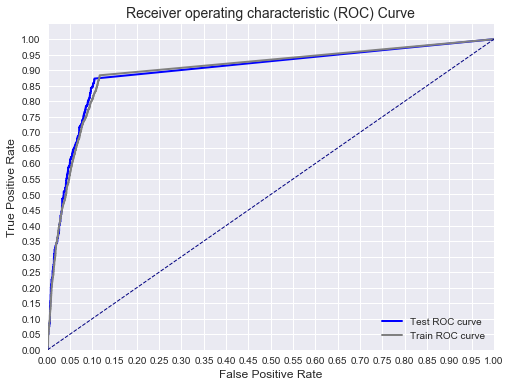

In [279]:
model(logreg)

***Model 4***
- Hyperparameters we've chosen ourselves
- One feature suggested by the RFECV function and coefficients

In [280]:
logreg = LogisticRegression(penalty = 'l2', fit_intercept = True, C = .001, max_iter = 100, tol = 0.0001)

Models Test Data Precision: 0.921
Train Data AUC: 0.899
Test Data AUC: 0.897

Cost/Benefit = 20.9 Dollars Per Shopping Session




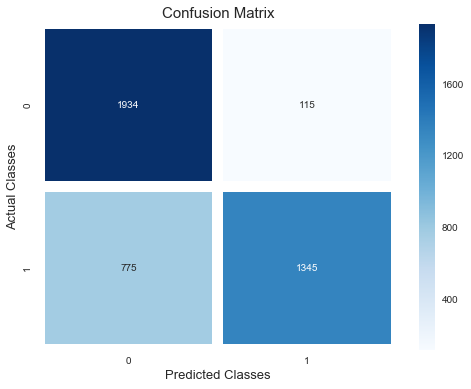

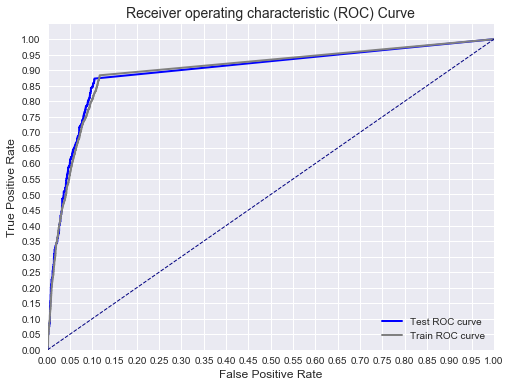

In [281]:
model(logreg)

------------------------------------------------------------------------------------------------------------------

#### Final Model

------------------------------------------------------------------------------------------------------------------

## Cost Benefit Analysis Result <a id='costbenefitanalysis'></a>

[Back to top](#top)

------------------------------------------------------------------------------------------------------------------
## Conclusion <a id='conclusion'></a>

[Back to top](#top)

**Question:** xx

**Answer:** xx

------------------------------------------------------------------------------------------------------------------
## Recommendations <a id='recommendation'></a>

[Back to top](#top)

------------------------------------------------------------------------------------------------------------------
## Future Work <a id='futurework'></a>

[Back to top](#top)